In [1]:
import pandas as pd
from plot_split_loader import plotwise_split, data_merge, plotwise_kfold, PlotwiseKFold

train1, train2, test1, test2 = plotwise_split()

combined_train = data_merge(train1, train2,
    indicator_features = ["LAT", "LON", "ALIVE_pre_burn", "CULL_pre_burn", "DIA_pre_burn", "HT_pre_burn", "CR_pre_burn",
                         "DRYBIO_AG_pre_burn", "ELEV", "SOFTWOOD", "YRS_SINCE_BURN", "NUM_BURNS",
                         "BURN_AREA_TOTAL"])
combined_test = data_merge(test1, test2,
    indicator_features = ["ALIVE_pre_burn", "CULL_pre_burn", "DIA_pre_burn", "HT_pre_burn", "CR_pre_burn",
                         "DRYBIO_AG_pre_burn", "ELEV", "SOFTWOOD", "YRS_SINCE_BURN", "NUM_BURNS",
                         "BURN_AREA_TOTAL"])


SPCD inconsistent; column will not be merged.
SPGRPCD inconsistent; column will not be merged.
SPCD inconsistent; column will not be merged.
SPGRPCD inconsistent; column will not be merged.


/Users/allierose/Library/CloudStorage/OneDrive-DukeUniversity/erdos/Erdos_Trees/machine_learning/plot_split_loader.py:115: DtypeWarning: Columns (55,59,63) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(trimmed_data_path)


## On to the data science!

In [2]:
combined_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7486 entries, 0 to 9711
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CN                  7486 non-null   int64  
 1   PLOT                7486 non-null   int64  
 2   LAT                 7486 non-null   float64
 3   LON                 7486 non-null   float64
 4   ALIVE_pre_burn      7486 non-null   int64  
 5   CULL_pre_burn       6784 non-null   float64
 6   DIA_pre_burn        7486 non-null   float64
 7   HT_pre_burn         7486 non-null   float64
 8   CR_pre_burn         7486 non-null   float64
 9   DRYBIO_AG_pre_burn  7486 non-null   float64
 10  ELEV                7486 non-null   float64
 11  SOFTWOOD            7486 non-null   int64  
 12  YRS_SINCE_BURN      7486 non-null   float64
 13  NUM_BURNS           7486 non-null   int64  
 14  BURN_AREA_TOTAL     7486 non-null   float64
 15  ALIVE_post_burn     7486 non-null   int64  
 16  CULL_post_b

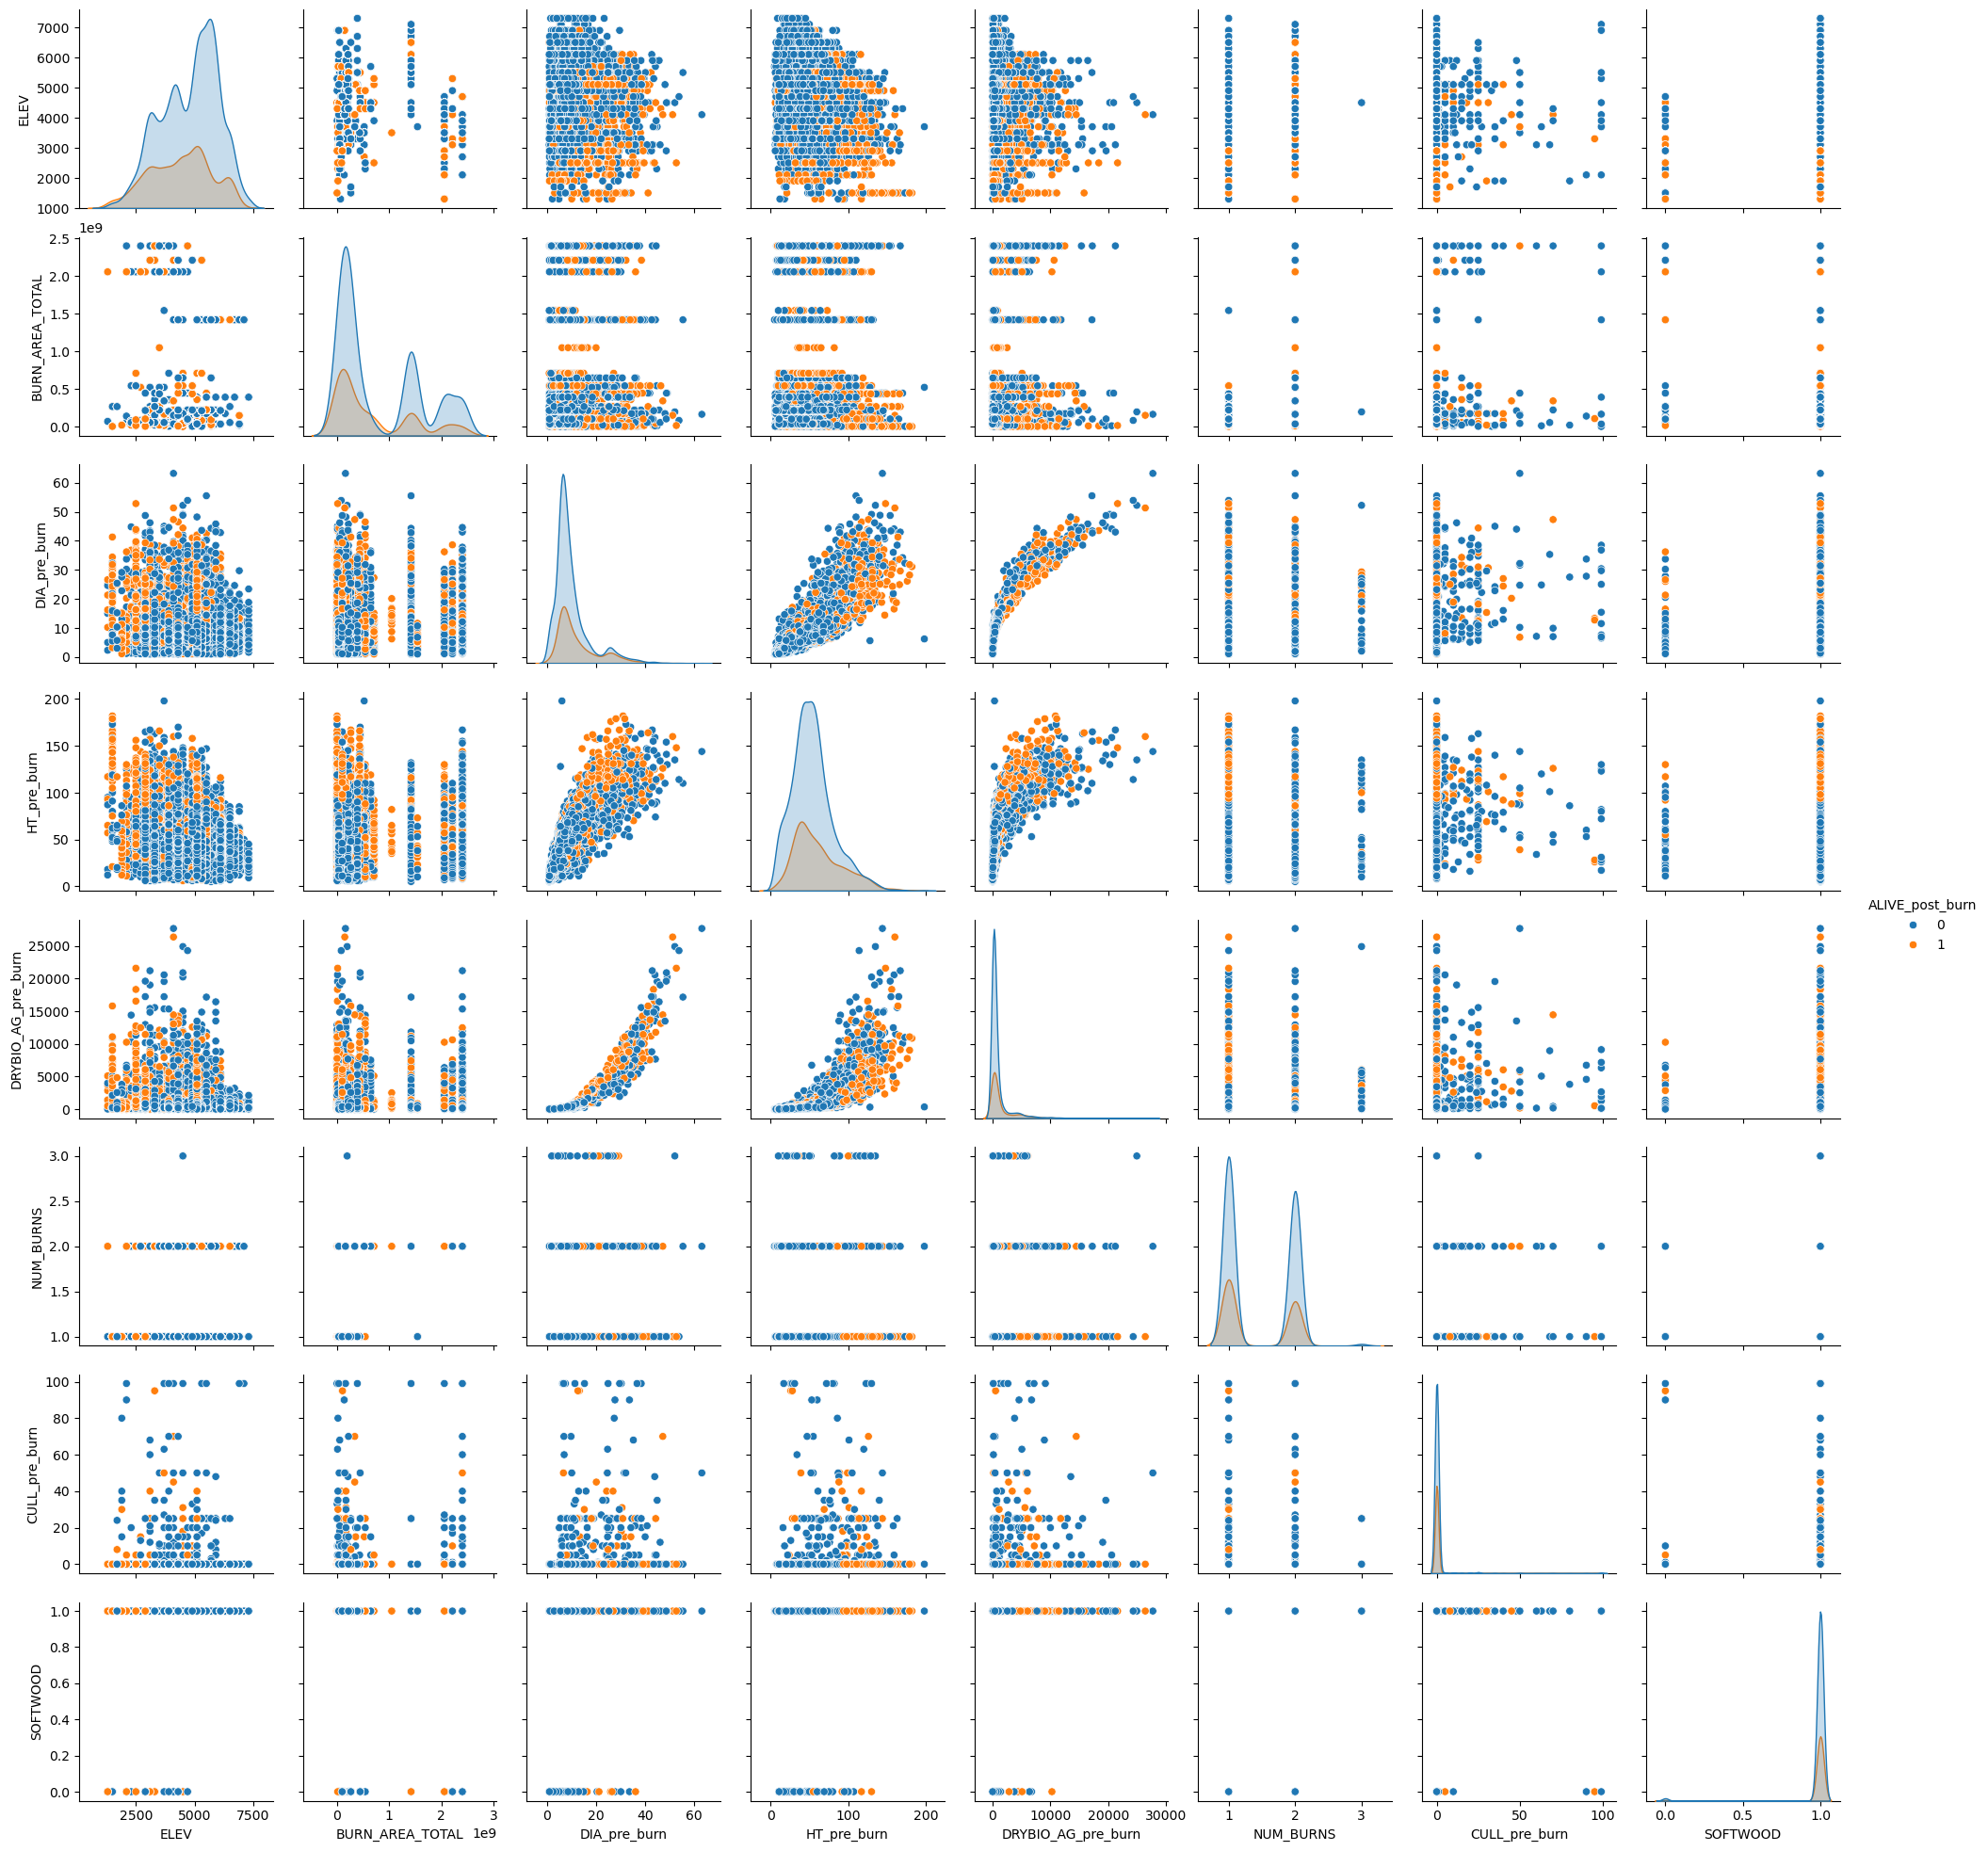

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.pairplot(combined_train[["ELEV", "BURN_AREA_TOTAL","DIA_pre_burn","HT_pre_burn","DRYBIO_AG_pre_burn","NUM_BURNS","CULL_pre_burn","ALIVE_post_burn","SOFTWOOD"]],hue="ALIVE_post_burn")

Based on these plots, we could maybe do some classification methods using diameter, height, cull damage, number of fires, and area of burn However, diameter, height, and dry bio age look to be highly correlated, so let's only use one. Also, it looks like a linear decision line could be drawn between height/diameter and elevation nicely. 

In [2]:
# Let's not do Cull for now as there are some nan values
indicator_features = ["ELEV","HT_pre_burn","BURN_AREA_TOTAL"]

**SVC**

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
import scipy.stats
from scipy.stats import uniform, randint
import numpy as np


In [6]:
n_splits = 5

## Make the kfold object
#kfold = StratifiedKFold(n_splits, 
 #                       random_state=218, 
 #                       shuffle=True)

dummy_clf_mostfrequent = DummyClassifier(strategy='most_frequent', random_state=218)
dummy_clf_stratified = DummyClassifier(strategy='stratified', random_state=218)
DummyAccuracies = np.zeros((n_splits, 2))


for i,(train_index, test_index) in enumerate(plotwise_kfold(combined_train)):
    trees_tt = combined_train.iloc[train_index]
    trees_ho = combined_train.iloc[test_index]
        
        
    dummy_clf_stratified.fit(trees_tt[indicator_features],trees_tt[['ALIVE_post_burn']])
    dummy_pred_stratified = dummy_clf_stratified.predict(trees_ho[indicator_features])
    dummy_clf_mostfrequent.fit(trees_tt[indicator_features],trees_tt[['ALIVE_post_burn']])
    dummy_pred_mostfrequent = dummy_clf_mostfrequent.predict(trees_ho[indicator_features])
    
    DummyAccuracies[i,0] = accuracy_score(trees_ho['ALIVE_post_burn'], dummy_pred_stratified)
    DummyAccuracies[i,1] = accuracy_score(trees_ho['ALIVE_post_burn'], dummy_pred_mostfrequent)



In [3]:
# Institiate plotwise KFold object
plotwise_cv = PlotwiseKFold(train_data=combined_train, n_splits=5)

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('svc', SVC())  # Classifier step
])
param_grid = {
    'svc__C': [0.1,1,10],
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#    'svc__degree': [2, 3],  # Applies only to 'poly'
#    'svc__gamma': ['scale', 'auto']  # Applies to 'rbf' and 'sigmoid'
}
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=plotwise_cv,  
    verbose=2, 
)
grid_search.fit(combined_train[indicator_features], combined_train['ALIVE_post_burn'].values)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.5s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.5s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.4s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.5s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.5s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.8s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.8s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.9s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.9s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.9s
[CV] END ........................svc__C=0.1, svc__kernel=rbf; total time=   1.1s
[CV] END ........................svc__C=0.1, svc

GridSearchCV(cv=PlotwiseKFold(n_splits=5, random_state=216, shuffle=True,
       train_data=                   CN   PLOT        LAT         LON  ALIVE_pre_burn  \
0       8601094010901  78293  46.007125 -117.618379               1
1       8601102010901  78293  46.007125 -117.618379               1
2       8601101010901  78293  46.007125 -117.618379               1
3    ...            NaN
9711     2.204000e+08                0             0.0

[7486 rows x 17 columns]),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1, 10],
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [4]:
# Find optimal parameters 
cv_results = pd.DataFrame(grid_search.cv_results_)
best_kernel = grid_search.best_params_['svc__kernel']
best_index = grid_search.best_index_  # Index of the best parameter set
print(cv_results.iloc[best_index])   # Full details of the best set


mean_fit_time                                     0.656798
std_fit_time                                      0.027297
mean_score_time                                   0.422847
std_score_time                                    0.026848
param_svc__C                                           0.1
param_svc__kernel                                      rbf
params               {'svc__C': 0.1, 'svc__kernel': 'rbf'}
split0_test_score                                 0.729918
split1_test_score                                 0.742647
split2_test_score                                 0.605048
split3_test_score                                     0.75
split4_test_score                                 0.804247
mean_test_score                                   0.726372
std_test_score                                    0.065757
rank_test_score                                          1
Name: 2, dtype: object


In [7]:
print(f"Accuracy of Dummy Classifier with Stratified Strategy: {np.mean(DummyAccuracies[:,0],):.4f}")
print(f"Accuracy of Dummy Classifier with Most Frequent Strategy: {np.mean(DummyAccuracies[:,1],):.4f}")

Accuracy of Dummy Classifier with Stratified Strategy: 0.5987
Accuracy of Dummy Classifier with Most Frequent Strategy: 0.7228


The SVC with the poly kernel did the best. Also it had a mean CV accuracy of 72.5% which is a bit above baseline.

In [24]:




plotwise_cv = PlotwiseKFold(train_data=combined_train, n_splits=5)

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('svc', SVC())  # Classifier step
])
param_grid = {
    'svc__C': [0.001, 0.01, 0.1,1,10],
    'svc__kernel': ['poly'],
#    'svc__degree': [2, 3],  # Applies only to 'poly'
#    'svc__gamma': ['scale', 'auto']  # Applies to 'rbf' and 'sigmoid'
}
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=plotwise_cv,  
    verbose=2, 
)
grid_search.fit(combined_train[indicator_features], combined_train['ALIVE_post_burn'].values)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .....................svc__C=0.001, svc__kernel=poly; total time=   0.6s
[CV] END .....................svc__C=0.001, svc__kernel=poly; total time=   0.5s
[CV] END .....................svc__C=0.001, svc__kernel=poly; total time=   0.5s
[CV] END .....................svc__C=0.001, svc__kernel=poly; total time=   0.6s
[CV] END .....................svc__C=0.001, svc__kernel=poly; total time=   0.6s
[CV] END ......................svc__C=0.01, svc__kernel=poly; total time=   0.6s
[CV] END ......................svc__C=0.01, svc__kernel=poly; total time=   0.6s
[CV] END ......................svc__C=0.01, svc__kernel=poly; total time=   0.6s
[CV] END ......................svc__C=0.01, svc__kernel=poly; total time=   0.7s
[CV] END ......................svc__C=0.01, svc__kernel=poly; total time=   0.6s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.8s
[CV] END .......................svc__C=0.1, svc__

GridSearchCV(cv=PlotwiseKFold(n_splits=5, random_state=216, shuffle=True,
       train_data=                   CN   PLOT        LAT         LON  ALIVE_pre_burn  \
0       8601094010901  78293  46.007125 -117.618379               1
1       8601102010901  78293  46.007125 -117.618379               1
2       8601101010901  78293  46.007125 -117.618379               1
3    ...            NaN
9711     2.204000e+08                0             0.0

[7486 rows x 17 columns]),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 10],
                         'svc__kernel': ['poly']},
             scoring='accuracy', verbose=2)

In [25]:
# Find optimal parameters 
cv_results = pd.DataFrame(grid_search.cv_results_)
best_kernel = grid_search.best_params_
best_index = grid_search.best_index_  # Index of the best parameter set
print(cv_results.iloc[best_index])   # Full details of the best set

mean_fit_time                                      0.714507
std_fit_time                                       0.035776
mean_score_time                                    0.079354
std_score_time                                      0.00523
param_svc__C                                            0.1
param_svc__kernel                                      poly
params               {'svc__C': 0.1, 'svc__kernel': 'poly'}
split0_test_score                                   0.72549
split1_test_score                                  0.742647
split2_test_score                                  0.607776
split3_test_score                                  0.750696
split4_test_score                                  0.800265
mean_test_score                                    0.725375
std_test_score                                      0.06384
rank_test_score                                           1
Name: 2, dtype: object


Seems that C= .1 gives the best accuracy score.

Let's try to see how the model does if we have different combos of the features

In [7]:
import itertools

# Example array

# Get all combinations with length 1 to the total number of components
all_combinations = []
for r in range(1, len(indicator_features) + 1):
    all_combinations.extend(itertools.combinations(indicator_features, r))

# Convert combinations to a list of lists for readability
all_combinations = [list(comb) for comb in all_combinations]
print(all_combinations)


[['ELEV'], ['HT_pre_burn'], ['BURN_AREA_TOTAL'], ['ELEV', 'HT_pre_burn'], ['ELEV', 'BURN_AREA_TOTAL'], ['HT_pre_burn', 'BURN_AREA_TOTAL'], ['ELEV', 'HT_pre_burn', 'BURN_AREA_TOTAL']]


In [9]:
Feature_Accuracies = np.zeros((n_splits,len(all_combinations)))
for i,(train_index, test_index) in enumerate(plotwise_kfold(combined_train)):
    trees_tt = combined_train.iloc[train_index]
    trees_ho = combined_train.iloc[test_index]
    for j,features in enumerate(all_combinations):
        pipe_rbf = Pipeline([('scale', StandardScaler()),
                            ('svm', SVC(C=.1,kernel= 'poly'))])
        
        pipe_rbf.fit(trees_tt[features],
                    trees_tt['ALIVE_post_burn'])

        
        pred_rbf = pipe_rbf.predict(trees_ho[features])


        Feature_Accuracies[i, j] = accuracy_score(trees_ho['ALIVE_post_burn'], pred_rbf)

In [10]:
mean_cv_accuracy = np.mean(Feature_Accuracies, axis=0)
optimal_index = np.argmax(mean_cv_accuracy)
optimal_features = all_combinations[optimal_index]
optimal_accuracy = mean_cv_accuracy[optimal_index]

mean_df = pd.DataFrame({
    "Features Used": all_combinations,
    "Mean": mean_cv_accuracy
})

print(mean_df)
print(f"The optimal combination of features was {optimal_features} which gave a mean CV accuracy of {optimal_accuracy:.3f}")

                          Features Used      Mean
0                                [ELEV]  0.722410
1                         [HT_pre_burn]  0.722410
2                     [BURN_AREA_TOTAL]  0.722410
3                   [ELEV, HT_pre_burn]  0.723206
4               [ELEV, BURN_AREA_TOTAL]  0.722410
5        [HT_pre_burn, BURN_AREA_TOTAL]  0.722410
6  [ELEV, HT_pre_burn, BURN_AREA_TOTAL]  0.725375
The optimal combination of features was ['ELEV', 'HT_pre_burn', 'BURN_AREA_TOTAL'] which gave a mean CV accuracy of 0.725


Okay so the best combination of features is in fact when all three are used. Let's see what happens if we use Cull too. We need to first get rid of the nan values for this. 

In [11]:
combined_train_trimmed = combined_train.dropna(subset=["CULL_pre_burn"])
combined_train_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6784 entries, 0 to 9711
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CN                  6784 non-null   int64  
 1   PLOT                6784 non-null   int64  
 2   LAT                 6784 non-null   float64
 3   LON                 6784 non-null   float64
 4   ALIVE_pre_burn      6784 non-null   int64  
 5   CULL_pre_burn       6784 non-null   float64
 6   DIA_pre_burn        6784 non-null   float64
 7   HT_pre_burn         6784 non-null   float64
 8   CR_pre_burn         6784 non-null   float64
 9   DRYBIO_AG_pre_burn  6784 non-null   float64
 10  ELEV                6784 non-null   float64
 11  SOFTWOOD            6784 non-null   int64  
 12  YRS_SINCE_BURN      6784 non-null   float64
 13  NUM_BURNS           6784 non-null   int64  
 14  BURN_AREA_TOTAL     6784 non-null   float64
 15  ALIVE_post_burn     6784 non-null   int64  
 16  CULL_post_b

In [13]:
Accuracies_includingCull = np.zeros((n_splits,1))
indicator_features = ["ELEV","HT_pre_burn","BURN_AREA_TOTAL","CULL_pre_burn"]
for i,(train_index, test_index) in enumerate(plotwise_kfold(combined_train_trimmed)):
    trees_tt = combined_train_trimmed.iloc[train_index]
    trees_ho = combined_train_trimmed.iloc[test_index]
    pipe_rbf = Pipeline([('scale', StandardScaler()),
                            ('svm', SVC(C=.1,kernel='poly'))])

        
    pipe_rbf.fit(trees_tt[indicator_features],
                    trees_tt['ALIVE_post_burn'])

        
    pred_rbf = pipe_rbf.predict(trees_ho[indicator_features])


    Accuracies_includingCull[i] = accuracy_score(trees_ho['ALIVE_post_burn'], pred_rbf)
print(f"The mean CV accuracy including Cull is {np.mean(Accuracies_includingCull):.3f}")

The mean CV accuracy including Cull is 0.710


Okay, so including Cull made the mean CV accuracy worse.

## **Model Tuning**
Let's try tuning gamma,coef0, and degree in the poly kernel to improve accuracy

In [10]:
import sys
indicator_features = ["ELEV","HT_pre_burn","BURN_AREA_TOTAL"]
plotwise_cv = PlotwiseKFold(train_data=combined_train, n_splits=5)

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('svc', SVC(C=.1,kernel='poly'))  # Classifier step
])
param_dist = {
    'svc__gamma': ['scale', 'auto', 0.1, 1],  # Discrete values for gamma
    'svc__degree': randint(2, 4),  # Random integer between 2 and 5 for degree
    'svc__coef0': uniform(0, 10)   # Uniform distribution from 0 to 10 for coef0
}

                        

grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    scoring='accuracy',
    cv=plotwise_cv,  
    n_iter=10,verbose=2, random_state=216 
)
sys.stdout.flush()
grid_search.fit(combined_train[indicator_features], combined_train['ALIVE_post_burn'].values)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END svc__coef0=0.35589034976299394, svc__degree=3, svc__gamma=auto; total time=   0.9s
[CV] END svc__coef0=0.35589034976299394, svc__degree=3, svc__gamma=auto; total time=   0.9s
[CV] END svc__coef0=0.35589034976299394, svc__degree=3, svc__gamma=auto; total time=   0.9s
[CV] END svc__coef0=0.35589034976299394, svc__degree=3, svc__gamma=auto; total time=   0.9s
[CV] END svc__coef0=0.35589034976299394, svc__degree=3, svc__gamma=auto; total time=   0.9s
[CV] END svc__coef0=6.8564104283934215, svc__degree=3, svc__gamma=auto; total time=   2.9s
[CV] END svc__coef0=6.8564104283934215, svc__degree=3, svc__gamma=auto; total time=   3.6s
[CV] END svc__coef0=6.8564104283934215, svc__degree=3, svc__gamma=auto; total time=   3.3s
[CV] END svc__coef0=6.8564104283934215, svc__degree=3, svc__gamma=auto; total time=   2.9s
[CV] END svc__coef0=6.8564104283934215, svc__degree=3, svc__gamma=auto; total time=   2.7s
[CV] END svc__coef0=2.41

RandomizedSearchCV(cv=PlotwiseKFold(n_splits=5, random_state=216, shuffle=True,
       train_data=                   CN   PLOT        LAT         LON  ALIVE_pre_burn  \
0       8601094010901  78293  46.007125 -117.618379               1
1       8601102010901  78293  46.007125 -117.618379               1
2       8601101010901  78293  46.007125 -117.618379               1
3    ...            NaN
9711     2.204000e+08                0             0.0

[7486 rows x 17 columns]),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc',
                                              SVC(C=0.1, kernel='poly'))]),
                   param_distributions={'svc__coef0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x17dbfb7d0>,
                                        'svc__degree': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17dcc71a0>,
                                        'svc__gamma': ['scale', 'auto', 0.1,
                                                       1]},
                   random_state=216, scoring='accuracy', verbose=2)

In [12]:
# Find optimal Gamma
cv_results = pd.DataFrame(grid_search.cv_results_)
best_kernel = grid_search.best_params_
best_index = grid_search.best_index_  # Index of the best parameter set
print(cv_results.iloc[best_index])   # Full details of the best set
print(cv_results.iloc[best_index]['params'])   # Full details of the best set


mean_fit_time                                                 1.168769
std_fit_time                                                  0.113945
mean_score_time                                               0.105657
std_score_time                                                0.007241
param_svc__coef0                                              5.109401
param_svc__degree                                                    3
param_svc__gamma                                                   0.1
params               {'svc__coef0': 5.109400764081563, 'svc__degree...
split0_test_score                                              0.72549
split1_test_score                                             0.743316
split2_test_score                                             0.608458
split3_test_score                                             0.750696
split4_test_score                                             0.805574
mean_test_score                                               0.726707
std_te

Okay so the best is coef0 of 5.11, degree of 3, and gamma of .1. It still only increases the accuracy to 72.67% from 72.5%

### **Final Model Test on Test Set**

In [14]:
indicator_features = ["ELEV","HT_pre_burn","BURN_AREA_TOTAL"]

# Fitting the best model to the entire training data set:

classifier_pipe = Pipeline([("Scaler", StandardScaler()), 
                            ('svc', SVC(kernel='poly',C=.1, gamma=.1,coef0=5.1))])
best_classifier = classifier_pipe.fit(combined_train[indicator_features], combined_train["ALIVE_post_burn"])

# Running the model on the test set now that it's been tuned:
preds = best_classifier.predict(combined_test[indicator_features])
print(accuracy_score(combined_test["ALIVE_post_burn"], preds))

0.7295392953929539


### **Baseline Model Test on Test Set**

In [15]:

dummy_clf_mostfrequent = DummyClassifier(strategy='most_frequent', random_state=216)
dummy_clf_stratified = DummyClassifier(strategy='stratified', random_state=216)

dummy_mostfrequent = dummy_clf_mostfrequent.fit(combined_train[indicator_features], combined_train["ALIVE_post_burn"])
dummy_stratified = dummy_clf_stratified.fit(combined_train[indicator_features], combined_train["ALIVE_post_burn"])

dummy_mostfreq_pred = dummy_mostfrequent.predict(combined_test[indicator_features])
dummy_stratified_pred = dummy_stratified.predict(combined_test[indicator_features])

print(f"The accuracy for the stratified dummy classifier is  {accuracy_score(combined_test["ALIVE_post_burn"], dummy_stratified_pred):.3f}")
print(f"The accuracy for the most frequent dummy classifier is  {accuracy_score(combined_test["ALIVE_post_burn"], dummy_mostfreq_pred):.3f}")

The accuracy for the stratified dummy classifier is  0.590
The accuracy for the most frequent dummy classifier is  0.728
